<a href="https://colab.research.google.com/github/Rafia-Shaikh-eng/Data-Science-Analytics/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Our Mission ##

Spam detection is one of the major applications of Machine Learning in the interwebs today. Pretty much all of the major email service providers have spam detection systems built in and automatically classify such mail as 'Junk Mail'.

In this mission we will be using the Naive Bayes algorithm to create a model that can classify [dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) SMS messages as spam or not spam, based on the training we give to the model. It is important to have some level of intuition as to what a spammy text message might look like. Usually they have words like 'free', 'win', 'winner', 'cash', 'prize' and the like in them as these texts are designed to catch your eye and in some sense tempt you to open them. Also, spam messages tend to have words written in all capitals and also tend to use a lot of exclamation marks. To the recipient, it is usually pretty straightforward to identify a spam text and our objective here is to train a model to do that for us!

Being able to identify spam messages is a binary classification problem as messages are classified as either 'Spam' or 'Not Spam' and nothing else. Also, this is a supervised learning problem, as we will be feeding a labelled dataset into the model, that it can learn from, to make future predictions.

### Step 0: Introduction to the Naive Bayes Theorem ###

Bayes theorem is one of the earliest probabilistic inference algorithms developed by Reverend Bayes (which he used to try and infer the existence of God no less) and still performs extremely well for certain use cases.

It's best to understand this theorem using an example. Let's say you are a member of the Secret Service and you have been deployed to protect the Democratic presidential nominee during one of his/her campaign speeches. Being a public event that is open to all, your job is not easy and you have to be on the constant lookout for threats. So one place to start is to put a certain threat-factor for each person. So based on the features of an individual, like the age, sex, and other smaller factors like is the person carrying a bag?, does the person look nervous? etc. you can make a judgement call as to if that person is viable threat.

If an individual ticks all the boxes up to a level where it crosses a threshold of doubt in your mind, you can take action and remove that person from the vicinity. The Bayes theorem works in the same way as we are computing the probability of an event(a person being a threat) based on the probabilities of certain related events(age, sex, presence of bag or not, nervousness etc. of the person).

One thing to consider is the independence of these features amongst each other. For example if a child looks nervous at the event then the likelihood of that person being a threat is not as much as say if it was a grown man who was nervous. To break this down a bit further, here there are two features we are considering, age AND nervousness. Say we look at these features individually, we could design a model that flags ALL persons that are nervous as potential threats. However, it is likely that we will have a lot of false positives as there is a strong chance that minors present at the event will be nervous. Hence by considering the age of a person along with the 'nervousness' feature we would definitely get a more accurate result as to who are potential threats and who aren't.

This is the 'Naive' bit of the theorem where it considers each feature to be independent of each other which may not always be the case and hence that can affect the final judgement.

In short, the Bayes theorem calculates the probability of a certain event happening(in our case, a message being  spam) based on the joint probabilistic distributions of certain other events(in our case, a message being classified as spam). We will dive into the workings of the Bayes theorem later in the mission, but first, let us understand the data we are going to work with.

### Step 1.1: Understanding our dataset ###


We will be using a [dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from the UCI Machine Learning repository which has a very good collection of datasets for experimental research purposes. The direct data link is [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/).


 **Here's a preview of the data:**

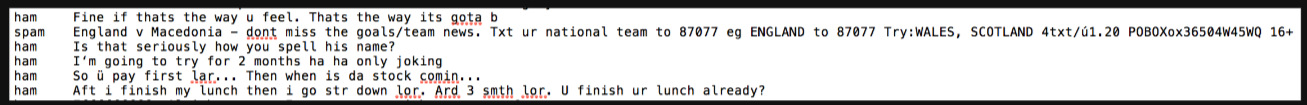

The columns in the data set are currently not named and as you can see, there are 2 columns.

The first column takes two values, 'ham' which signifies that the message is not spam, and 'spam' which signifies that the message is spam.

The second column is the text content of the SMS message that is being classified.

>**Instructions:**
* Import the dataset into a pandas dataframe using the read_table method. Because this is a tab separated dataset we will be using '\t' as the value for the 'sep' argument which specifies this format.
* Also, rename the column names by specifying a list ['label, 'sms_message'] to the 'names' argument of read_table().
* Print the first five values of the dataframe with the new column names.

In [1]:
import pandas as pd

# Dataset from - https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
df = pd.read_table('/content/SMSSpamCollection.txt', header=None, names=['label', 'sms_message'])
#df.columns = ['label', 'sms_message']

# Output printing out first 5 columns
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Step 1.2: Data Preprocessing ###

Now that we have a basic understanding of what our dataset looks like, lets convert our labels to binary variables, 0 to represent 'ham'(i.e. not spam) and 1 to represent 'spam' for ease of computation.

You might be wondering why do we need to do this step? The answer to this lies in how scikit-learn handles inputs. Scikit-learn only deals with numerical values and hence if we were to leave our label values as strings, scikit-learn would do the conversion internally(more specifically, the string labels will be cast to unknown float values).

Our model would still be able to make predictions if we left our labels as strings but we could have issues later when calculating performance metrics, for example when calculating our precision and recall scores. Hence, to avoid unexpected 'gotchas' later, it is good practice to have our categorical values be fed into our model as integers.

>**Instructions: **
* Convert the values in the 'label' column to numerical values using map method as follows:
{'ham':0, 'spam':1} This maps the 'ham' value to 0 and the 'spam' value to 1.
* Also, to get an idea of the size of the dataset we are dealing with, print out number of rows and columns using
'shape'.

In [2]:
category_mapping = {
    'ham': 0,
    'spam': 1
}

df['label'] = df.label.map(category_mapping)

### Step 2.1: Bag of words ###

What we have here in our data set is a large collection of text data (5,572 rows of data). Most ML algorithms rely on numerical data to be fed into them as input, and email/sms messages are usually text heavy.

Here we'd like to introduce the Bag of Words(BoW) concept which is a term used to specify the problems that have a 'bag of words' or a collection of text data that needs to be worked with. The basic idea of BoW is to take a piece of text and count the frequency of the words in that text. It is important to note that the BoW concept treats each word individually and the order in which the words occur does not matter.

Using a process which we will go through now, we can convert a collection of documents to a matrix, with each document being a row and each word(token) being the column, and the corresponding (row,column) values being the frequency of occurrence of each word or token in that document.

For example:

Lets say we have 4 documents as follows:

`['Hello, how are you!',
'Win money, win from home.',
'Call me now',
'Hello, Call you tomorrow?']`

Our objective here is to convert this set of text to a frequency distribution matrix, as follows:

<img src="images/countvectorizer.png" height="542" width="542">

Here as we can see, the documents are numbered in the rows, and each word is a column name, with the corresponding value being the frequency of that word in the document.

Lets break this down and see how we can do this conversion using a small set of documents.

To handle this, we will be using sklearns
[count vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) method which does the following:

* It tokenizes the string(separates the string into individual words) and gives an integer ID to each token.
* It counts the occurrence of each of those tokens.

** Please Note: **

* The CountVectorizer method automatically converts all tokenized words to their lower case form so that it does not treat words like 'He' and 'he' differently. It does this using the `lowercase` parameter which is by default set to `True`.

* It also ignores all punctuation so that words followed by a punctuation mark (for example: 'hello!') are not treated differently than the same words not prefixed or suffixed by a punctuation mark (for example: 'hello'). It does this using the `token_pattern` parameter which has a default regular expression which selects tokens of 2 or more alphanumeric characters.

* The third parameter to take note of is the `stop_words` parameter. Stop words refer to the most commonly used words in a language. They include words like 'am', 'an', 'and', 'the' etc. By setting this parameter value to `english`, CountVectorizer will automatically ignore all words(from our input text) that are found in the built in list of english stop words in scikit-learn. This is extremely helpful as stop words can skew our calculations when we are trying to find certain key words that are indicative of spam.

We will dive into the application of each of these into our model in a later step, but for now it is important to be aware of such preprocessing techniques available to us when dealing with textual data.

### Step 2.2: Implementing Bag of Words from scratch ###

Before we dive into scikit-learn's Bag of Words(BoW) library to do the dirty work for us, let's implement it ourselves first so that we can understand what's happening behind the scenes.

** Step 1: Convert all strings to their lower case form. **

Let's say we have a document set:

```
documents = ['Hello, how are you!',
             'Win money, win from home.',
             'Call me now.',
             'Hello, Call hello you tomorrow?']
```
>>** Instructions: **
* Convert all the strings in the documents set to their lower case. Save them into a list called 'lower_case_documents'. You can convert strings to their lower case in python by using the lower() method.


In [3]:
documents = ['Hello, how are you!',
             'Win money, win from home.',
             'Call me now.',
             'Hello, Call hello you tomorrow?']

lower_case_documents = []
for i in documents:
    lower_case_documents.append(i.lower())
print(lower_case_documents)

['hello, how are you!', 'win money, win from home.', 'call me now.', 'hello, call hello you tomorrow?']


**Step 2: Removing all punctuations**

>>**Instructions:**
Remove all punctuation from the strings in the document set. Save them into a list called
'sans_punctuation_documents'.

In [4]:
'''
Solution:
'''
sans_punctuation_documents = []
import string

for i in lower_case_documents:
    #sans_punctuation_documents.append(i.replace('.','').replace(',','').replace('?','').replace('!',''))
    sans_punctuation_documents.append(i.translate(str.maketrans('','',string.punctuation)))

print(sans_punctuation_documents)

['hello how are you', 'win money win from home', 'call me now', 'hello call hello you tomorrow']


** Step 3: Tokenization **

Tokenizing a sentence in a document set means splitting up a sentence into individual words using a delimiter. The delimiter specifies what character we will use to identify the beginning and the end of a word(for example we could use a single space as the delimiter for identifying words in our document set.)

>>**Instructions:**
Tokenize the strings stored in 'sans_punctuation_documents' using the split() method. and store the final document set
in a list called 'preprocessed_documents'.


In [5]:
preprocessed_documents = []
for i in sans_punctuation_documents:
    preprocessed_documents.append(i.split(' '))
print(preprocessed_documents)

[['hello', 'how', 'are', 'you'], ['win', 'money', 'win', 'from', 'home'], ['call', 'me', 'now'], ['hello', 'call', 'hello', 'you', 'tomorrow']]


** Step 4: Count frequencies **

Now that we have our document set in the required format, we can proceed to counting the occurrence of each word in each document of the document set. We will use the `Counter` method from the Python `collections` library for this purpose.

`Counter` counts the occurrence of each item in the list and returns a dictionary with the key as the item being counted and the corresponding value being the count of that item in the list.

>>**Instructions:**
Using the Counter() method and preprocessed_documents as the input, create a dictionary with the keys being each word in each document and the corresponding values being the frequency of occurrence of that word. Save each Counter dictionary as an item in a list called 'frequency_list'.


In [6]:
frequency_list = []
import pprint
from collections import Counter

for i in preprocessed_documents:
    frequency = Counter(i)
    frequency_list.append(frequency)

pprint.pprint(frequency_list)

[Counter({'hello': 1, 'how': 1, 'are': 1, 'you': 1}),
 Counter({'win': 2, 'money': 1, 'from': 1, 'home': 1}),
 Counter({'call': 1, 'me': 1, 'now': 1}),
 Counter({'hello': 2, 'call': 1, 'you': 1, 'tomorrow': 1})]


Congratulations! You have implemented the Bag of Words process from scratch! As we can see in our previous output, we have a frequency distribution dictionary which gives a clear view of the text that we are dealing with.

We should now have a solid understanding of what is happening behind the scenes in the `sklearn.feature_extraction.text.CountVectorizer` method of scikit-learn.

We will now implement `sklearn.feature_extraction.text.CountVectorizer` method in the next step.

### Step 2.3: Implementing Bag of Words in scikit-learn ###

Now that we have implemented the BoW concept from scratch, let's go ahead and use scikit-learn to do this process in a clean and succinct way. We will use the same document set as we used in the previous step.

In [7]:
'''
Here we will look to create a frequency matrix on a smaller document set to make sure we understand how the
document-term matrix generation happens. We have created a sample document set 'documents'.
'''
documents = ['Hello, how are you!',
                'Win money, win from home.',
                'Call me now.',
                'Hello, Call hello you tomorrow?']

>>**Instructions:**
Import the sklearn.feature_extraction.text.CountVectorizer method and create an instance of it called 'count_vector'.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

** Data preprocessing with CountVectorizer() **

In Step 2.2, we implemented a version of the CountVectorizer() method from scratch that entailed cleaning our data first. This cleaning involved converting all of our data to lower case and removing all punctuation marks. CountVectorizer() has certain parameters which take care of these steps for us. They are:

* `lowercase = True`
    
    The `lowercase` parameter has a default value of `True` which converts all of our text to its lower case form.


* `token_pattern = (?u)\\b\\w\\w+\\b`
    
    The `token_pattern` parameter has a default regular expression value of `(?u)\\b\\w\\w+\\b` which ignores all punctuation marks and treats them as delimiters, while accepting alphanumeric strings of length greater than or equal to 2, as individual tokens or words.


* `stop_words`

    The `stop_words` parameter, if set to `english` will remove all words from our document set that match a list of English stop words which is defined in scikit-learn. Considering the size of our dataset and the fact that we are dealing with SMS messages and not larger text sources like e-mail, we will not be setting this parameter value.

You can take a look at all the parameter values of your `count_vector` object by simply printing out the object as follows:

In [9]:
'''
Practice node:
Print the 'count_vector' object which is an instance of 'CountVectorizer()'
'''
print(count_vector)

CountVectorizer()


>>**Instructions:**
Fit your document dataset to the CountVectorizer object you have created using fit(), and get the list of words
which have been categorized as features using the get_feature_names() method.

In [12]:
count_vector.fit(documents)
count_vector.get_feature_names_out()

array(['are', 'call', 'from', 'hello', 'home', 'how', 'me', 'money',
       'now', 'tomorrow', 'win', 'you'], dtype=object)

The `get_feature_names()` method returns our feature names for this dataset, which is the set of words that make up our vocabulary for 'documents'.

>>**Instructions:**
Create a matrix with the rows being each of the 4 documents, and the columns being each word.
The corresponding (row, column) value is the frequency of occurrence of that word(in the column) in a particular
document(in the row). You can do this using the transform() method and passing in the document data set as the
argument. The transform() method returns a matrix of numpy integers, you can convert this to an array using
toarray(). Call the array 'doc_array'


In [13]:
doc_array = count_vector.transform(documents).toarray()
doc_array

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1]])

Now we have a clean representation of the documents in terms of the frequency distribution of the words in them. To make it easier to understand our next step is to convert this array into a dataframe and name the columns appropriately.

>>**Instructions:**
Convert the array we obtained, loaded into 'doc_array', into a dataframe and set the column names to
the word names(which you computed earlier using get_feature_names(). Call the dataframe 'frequency_matrix'.


In [15]:
frequency_matrix = pd.DataFrame(doc_array, columns=count_vector.get_feature_names_out())
frequency_matrix

,are,call,from,hello,home,how,me,money,now,tomorrow,win,you
0,1,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,2,0
2,0,1,0,0,0,0,1,0,1,0,0,0
3,0,1,0,2,0,0,0,0,0,1,0,1


Congratulations! You have successfully implemented a Bag of Words problem for a document dataset that we created.

One potential issue that can arise from using this method out of the box is the fact that if our dataset of text is extremely large(say if we have a large collection of news articles or email data), there will be certain values that are more common that others simply due to the structure of the language itself. So for example words like 'is', 'the', 'an', pronouns, grammatical constructs etc could skew our matrix and affect our analyis.

There are a couple of ways to mitigate this. One way is to use the `stop_words` parameter and set its value to `english`. This will automatically ignore all words(from our input text) that are found in a built in list of English stop words in scikit-learn.

Another way of mitigating this is by using the [tfidf](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) method. This method is out of scope for the context of this lesson.

### Step 3.1: Training and testing sets ###

Now that we have understood how to deal with the Bag of Words problem we can get back to our dataset and proceed with our analysis. Our first step in this regard would be to split our dataset into a training and testing set so we can test our model later.


>>**Instructions:**
Split the dataset into a training and testing set by using the train_test_split method in sklearn. Split the data
using the following variables:
* `X_train` is our training data for the 'sms_message' column.
* `y_train` is our training data for the 'label' column
* `X_test` is our testing data for the 'sms_message' column.
* `y_test` is our testing data for the 'label' column
Print out the number of rows we have in each our training and testing data.


In [17]:
!pip install sklearn.cross_validation

ERROR: Could not find a version that satisfies the requirement sklearn.cross_validation (from versions: none)
ERROR: No matching distribution found for sklearn.cross_validation


In [18]:
# NOTE: sklearn.cross_validation will be deprecated soon to sklearn.model_selection

# split into training and testing sets
# USE from sklearn.model_selection import train_test_split to avoid seeing deprecation warning.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['sms_message'],
                                                    df['label'],
                                                    random_state=1)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


### Step 3.2: Applying Bag of Words processing to our dataset. ###

Now that we have split the data, our next objective is to follow the steps from Step 2: Bag of words and convert our data into the desired matrix format. To do this we will be using CountVectorizer() as we did before. There are two  steps to consider here:

* Firstly, we have to fit our training data (`X_train`) into `CountVectorizer()` and return the matrix.
* Secondly, we have to transform our testing data (`X_test`) to return the matrix.

Note that `X_train` is our training data for the 'sms_message' column in our dataset and we will be using this to train our model.

`X_test` is our testing data for the 'sms_message' column and this is the data we will be using(after transformation to a matrix) to make predictions on. We will then compare those predictions with `y_test` in a later step.

For now, we have provided the code that does the matrix transformations for you!

In [19]:
'''
[Practice Node]

The code for this segment is in 2 parts. Firstly, we are learning a vocabulary dictionary for the training data
and then transforming the data into a document-term matrix; secondly, for the testing data we are only
transforming the data into a document-term matrix.

This is similar to the process we followed in Step 2.3

We will provide the transformed data to students in the variables 'training_data' and 'testing_data'.
'''

"\n[Practice Node]\n\nThe code for this segment is in 2 parts. Firstly, we are learning a vocabulary dictionary for the training data \nand then transforming the data into a document-term matrix; secondly, for the testing data we are only \ntransforming the data into a document-term matrix.\n\nThis is similar to the process we followed in Step 2.3\n\nWe will provide the transformed data to students in the variables 'training_data' and 'testing_data'.\n"

In [20]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

### Step 4.1: Bayes Theorem implementation from scratch ###

Now that we have our dataset in the format that we need, we can move onto the next portion of our mission which is the  algorithm we will use to make our predictions to classify a message as spam or not spam. Remember that at the start of the mission we briefly discussed the Bayes theorem but now we shall go into a little more detail. In layman's terms, the Bayes theorem calculates the probability of an event occurring, based on certain other probabilities that are related to the event in question. It is  composed of a  prior(the probabilities that we are aware of or that is given to us) and the posterior(the probabilities we are looking to compute using the priors).

Let us implement the Bayes Theorem from scratch using a simple example. Let's say we are trying to find the odds of an individual having diabetes, given that he or she was tested for it and got a positive result.
In the medical field, such probabilies play a very important role as it usually deals with life and death situations.

We assume the following:

`P(D)` is the probability of a person having Diabetes. It's value is `0.01` or in other words, 1% of the general population has diabetes(Disclaimer: these values are assumptions and are not reflective of any medical study).

`P(Pos)` is the probability of getting a positive test result.

`P(Neg)` is the probability of getting a negative test result.

`P(Pos|D)` is the probability of getting a positive result on a test done for detecting diabetes, given that you have diabetes. This has a value `0.9`. In other words the test is correct 90% of the time. This is also called the Sensitivity or True Positive Rate.

`P(Neg|~D)` is the probability of getting a negative result on a test done for detecting diabetes, given that you do not have diabetes. This also has a value of `0.9` and is therefore correct, 90% of the time. This is also called the Specificity or True Negative Rate.

The Bayes formula is as follows:

<img src="images/bayes_formula.png" height="242" width="242">

* `P(A)` is the prior probability of A occurring independently. In our example this is `P(D)`. This value is given to us.

* `P(B)` is the prior probability of B occurring independently. In our example this is `P(Pos)`.

* `P(A|B)` is the posterior probability that A occurs given B. In our example this is `P(D|Pos)`. That is, **the probability of an individual having diabetes, given that, that individual got a positive test result. This is the value that we are looking to calculate.**

* `P(B|A)` is the likelihood probability of B occurring, given A. In our example this is `P(Pos|D)`. This value is given to us.

Putting our values into the formula for Bayes theorem we get:

`P(D|Pos) = P(D) * P(Pos|D) / P(Pos)`

The probability of getting a positive test result `P(Pos)` can be calculated using the Sensitivity and Specificity as follows:

`P(Pos) = [P(D) * Sensitivity] + [P(~D) * (1-Specificity))]`

In [ ]:
'''
Instructions:
Calculate probability of getting a positive test result, P(Pos)
'''

In [21]:
'''
Solution (skeleton code will be provided)
'''
# P(D)
p_diabetes = 0.01

# P(~D)
p_no_diabetes = 0.99

# Sensitivity or P(Pos|D)
p_pos_diabetes = 0.9

# Specificity or P(Neg|~D)
p_neg_no_diabetes = 0.9

p_pos_no_diabetes = 1-p_neg_no_diabetes

# P(Pos)
p_pos = (p_diabetes * p_pos_diabetes) + (p_no_diabetes * p_pos_no_diabetes)
print('The probability of getting a positive test result P(Pos) is: {}',format(p_pos))

The probability of getting a positive test result P(Pos) is: {} 0.10799999999999998


**Using all of this information we can calculate our posteriors as follows:**
    
The probability of an individual having diabetes, given that, that individual got a positive test result:

`P(D|Pos) = (P(D) * Sensitivity)) / P(Pos)`

The probability of an individual not having diabetes, given that, that individual got a positive test result:

`P(~D|Pos) = (P(~D) * (1-Specificity)) / P(Pos)`

The sum of our posteriors will always equal `1`.

In [ ]:
'''
Instructions:
Compute the probability of an individual having diabetes, given that, that individual got a positive test result.
In other words, compute P(D|Pos).

The formula is: P(D|Pos) = (P(D) * P(Pos|D) / P(Pos)
'''

In [22]:
'''
Solution
'''
# P(D|Pos)
p_diabetes_pos = p_diabetes * p_pos_diabetes / p_pos
print('Probability of an individual having diabetes, given that that individual got a positive test result is:\
',format(p_diabetes_pos))

Probability of an individual having diabetes, given that that individual got a positive test result is: 0.08333333333333336


In [23]:
'''
Instructions:
Compute the probability of an individual not having diabetes, given that, that individual got a positive test result.
In other words, compute P(~D|Pos).

The formula is: P(~D|Pos) = P(~D) * P(Pos|~D) / P(Pos)

Note that P(Pos|~D) can be computed as 1 - P(Neg|~D).

Therefore:
P(Pos|~D) = p_pos_no_diabetes = 1 - 0.9 = 0.1
'''

'\nInstructions:\nCompute the probability of an individual not having diabetes, given that, that individual got a positive test result.\nIn other words, compute P(~D|Pos).\n\nThe formula is: P(~D|Pos) = P(~D) * P(Pos|~D) / P(Pos)\n\nNote that P(Pos|~D) can be computed as 1 - P(Neg|~D). \n\nTherefore:\nP(Pos|~D) = p_pos_no_diabetes = 1 - 0.9 = 0.1\n'

In [24]:
'''
Solution
'''
# P(Pos|~D)
p_pos_no_diabetes = 0.1

# P(~D|Pos)
p_no_diabetes_pos = p_no_diabetes * p_pos_no_diabetes / p_pos
print('Probability of an individual not having diabetes, given that that individual got a positive test result is:'\
,p_no_diabetes_pos)

Probability of an individual not having diabetes, given that that individual got a positive test result is: 0.9166666666666669


Congratulations! You have implemented Bayes theorem from scratch. Your analysis shows that even if you get a positive test result, there is only a 8.3% chance that you actually have diabetes and a 91.67% chance that you do not have diabetes. This is of course assuming that only 1% of the entire population has diabetes which of course is only an assumption.

**What does the term 'Naive' in 'Naive Bayes' mean ?**

The term 'Naive' in Naive Bayes comes from the fact that the algorithm considers the features that it is using to make the predictions to be independent of each other, which may not always be the case. So in our Diabetes example, we are considering only one feature, that is the test result. Say we added another feature, 'exercise'. Let's say this feature has a binary value of `0` and `1`, where the former signifies that the individual exercises less than or equal to 2 days a week and the latter signifies that the individual exercises greater than or equal to 3 days a week. If we had to use both of these features, namely the test result and the value of the 'exercise' feature, to compute our final probabilities, Bayes' theorem would fail. Naive Bayes' is an extension of Bayes' theorem that assumes that all the features are independent of each other.

### Step 4.2: Naive Bayes implementation from scratch ###



Now that you have understood the ins and outs of Bayes Theorem, we will extend it to consider cases where we have more than feature.

Let's say that we have two political parties' candidates, 'Jill Stein' of the Green Party and 'Gary Johnson' of the Libertarian Party and we have the probabilities of each of these candidates saying the words 'freedom', 'immigration' and 'environment' when they give a speech:

* Probability that Jill Stein says 'freedom': 0.1 ---------> `P(F|J)`
* Probability that Jill Stein says 'immigration': 0.1 -----> `P(I|J)`
* Probability that Jill Stein says 'environment': 0.8 -----> `P(E|J)`


* Probability that Gary Johnson says 'freedom': 0.7 -------> `P(F|G)`
* Probability that Gary Johnson says 'immigration': 0.2 ---> `P(I|G)`
* Probability that Gary Johnson says 'environment': 0.1 ---> `P(E|G)`


And let us also assume that the probability of Jill Stein giving a speech, `P(J)` is `0.5` and the same for Gary Johnson, `P(G) = 0.5`.


Given this, what if we had to find the probabilities of Jill Stein saying the words 'freedom' and 'immigration'? This is where the Naive Bayes'theorem comes into play as we are considering two features, 'freedom' and 'immigration'.

Now we are at a place where we can define the formula for the Naive Bayes' theorem:

<img src="images/naivebayes.png" height="342" width="342">

Here, `y` is the class variable or in our case the name of the candidate and `x1` through `xn` are the feature vectors or in our case the individual words. The theorem makes the assumption that each of the feature vectors or words (`xi`) are independent of each other.

To break this down, we have to compute the following posterior probabilities:

* `P(J|F,I)`: Probability of Jill Stein saying the words Freedom and Immigration.

    Using the formula and our knowledge of Bayes' theorem, we can compute this as follows: `P(J|F,I)` = `(P(J) * P(F|J) * P(I|J)) / P(F,I)`. Here `P(F,I)` is the probability of the words 'freedom' and 'immigration' being said in a speech.
    

* `P(G|F,I)`: Probability of Gary Johnson saying the words Freedom and Immigration.  
    
    Using the formula, we can compute this as follows: `P(G|F,I)` = `(P(G) * P(F|G) * P(I|G)) / P(F,I)`

In [25]:
'''
Instructions: Compute the probability of the words 'freedom' and 'immigration' being said in a speech, or
P(F,I).

The first step is multiplying the probabilities of Jill Stein giving a speech with her individual
probabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_j_text

The second step is multiplying the probabilities of Gary Johnson giving a speech with his individual
probabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_g_text

The third step is to add both of these probabilities and you will get P(F,I).
'''

"\nInstructions: Compute the probability of the words 'freedom' and 'immigration' being said in a speech, or\nP(F,I).\n\nThe first step is multiplying the probabilities of Jill Stein giving a speech with her individual \nprobabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_j_text\n\nThe second step is multiplying the probabilities of Gary Johnson giving a speech with his individual \nprobabilities of saying the words 'freedom' and 'immigration'. Store this in a variable called p_g_text\n\nThe third step is to add both of these probabilities and you will get P(F,I).\n"

In [26]:
'''
Solution: Step 1
'''
# P(J)
p_j = 0.5

# P(F/J)
p_j_f = 0.1

# P(I/J)
p_j_i = 0.1

p_j_text = p_j * p_j_f * p_j_i
print(p_j_text)

0.005000000000000001


In [27]:
'''
Solution: Step 2
'''
# P(G)
p_g = 0.5

# P(F/G)
p_g_f = 0.7

# P(I/G)
p_g_i = 0.2

p_g_text = p_g * p_g_f * p_g_i
print(p_g_text)

0.06999999999999999


In [28]:
'''
Solution: Step 3: Compute P(F,I) and store in p_f_i
'''
p_f_i = p_j_text + p_g_text
print('Probability of words freedom and immigration being said are: ', format(p_f_i))

Probability of words freedom and immigration being said are:  0.075


Now we can compute the probability of `P(J|F,I)`, that is the probability of Jill Stein saying the words Freedom and Immigration and `P(G|F,I)`, that is the probability of Gary Johnson saying the words Freedom and Immigration.

In [29]:
'''
Instructions:
Compute P(J|F,I) using the formula P(J|F,I) = (P(J) * P(F|J) * P(I|J)) / P(F,I) and store it in a variable p_j_fi
'''

'\nInstructions:\nCompute P(J|F,I) using the formula P(J|F,I) = (P(J) * P(F|J) * P(I|J)) / P(F,I) and store it in a variable p_j_fi\n'

In [30]:
'''
Solution
'''
p_j_fi = p_g_text / p_f_i
print('The probability of Jill Stein saying the words Freedom and Immigration: ', format(p_j_fi))

The probability of Jill Stein saying the words Freedom and Immigration:  0.9333333333333332


In [31]:
'''
Instructions:
Compute P(G|F,I) using the formula P(G|F,I) = (P(G) * P(F|G) * P(I|G)) / P(F,I) and store it in a variable p_g_fi
'''

'\nInstructions:\nCompute P(G|F,I) using the formula P(G|F,I) = (P(G) * P(F|G) * P(I|G)) / P(F,I) and store it in a variable p_g_fi\n'

In [32]:
'''
Solution
'''
p_g_fi = p_g_text / p_f_i
print('The probability of Gary Johnson saying the words Freedom and Immigration: ', format(p_g_fi))

The probability of Gary Johnson saying the words Freedom and Immigration:  0.9333333333333332


And as we can see, just like in the Bayes' theorem case, the sum of our posteriors is equal to 1. Congratulations! You have implemented the Naive Bayes' theorem from scratch. Our analysis shows that there is only a 6.6% chance that Jill Stein of the Green Party uses the words 'freedom' and 'immigration' in her speech as compared the the 93.3% chance for Gary Johnson of the Libertarian party.

Another more generic example of Naive Bayes' in action is as when we search for the term 'Sacramento Kings' in a search engine. In order for us to get the results pertaining to the Scramento Kings NBA basketball team, the search engine needs to be able to associate the two words together and not treat them individually, in which case we would get results of images tagged with 'Sacramento' like pictures of city landscapes and images of 'Kings' which could be pictures of crowns or kings from history when what we are looking to get are images of the basketball team. This is a classic case of the search engine treating the words as independent entities and hence being 'naive' in its approach.


Applying this to our problem of classifying messages as spam, the Naive Bayes algorithm *looks at each word individually and not as associated entities* with any kind of link between them. In the case of spam detectors, this usually works as there are certain red flag words which can almost guarantee its classification as spam, for example emails with words like 'viagra' are usually classified as spam.

### Step 5: Naive Bayes implementation using scikit-learn ###

Thankfully, sklearn has several Naive Bayes implementations that we can use and so we do not have to do the math from scratch. We will be using sklearns `sklearn.naive_bayes` method to make predictions on our dataset.

Specifically, we will be using the multinomial Naive Bayes implementation. This particular classifier is suitable for classification with discrete features (such as in our case, word counts for text classification). It takes in integer word counts as its input. On the other hand Gaussian Naive Bayes is better suited for continuous data as it assumes that the input data has a Gaussian(normal) distribution.

In [33]:
'''
Instructions:

We have loaded the training data into the variable 'training_data' and the testing data into the
variable 'testing_data'.

Import the MultinomialNB classifier and fit the training data into the classifier using fit(). Name your classifier
'naive_bayes'. You will be training the classifier using 'training_data' and y_train' from our split earlier.
'''

"\nInstructions:\n\nWe have loaded the training data into the variable 'training_data' and the testing data into the \nvariable 'testing_data'.\n\nImport the MultinomialNB classifier and fit the training data into the classifier using fit(). Name your classifier\n'naive_bayes'. You will be training the classifier using 'training_data' and y_train' from our split earlier. \n"

In [34]:
'''
Solution
'''
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB()

In [35]:
'''
Instructions:
Now that our algorithm has been trained using the training data set we can now make some predictions on the test data
stored in 'testing_data' using predict(). Save your predictions into the 'predictions' variable.
'''

"\nInstructions:\nNow that our algorithm has been trained using the training data set we can now make some predictions on the test data\nstored in 'testing_data' using predict(). Save your predictions into the 'predictions' variable.\n"

In [36]:
'''
Solution
'''
predictions = naive_bayes.predict(testing_data)

Now that predictions have been made on our test set, we need to check the accuracy of our predictions.

### Step 6: Evaluating our model ###

Now that we have made predictions on our test set, our next goal is to evaluate how well our model is doing. There are various mechanisms for doing so, but first let's do quick recap of them.

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score.

We will be using all 4 metrics to make sure our model does well. For all 4 metrics whose values can range from 0 to 1, having a score as close to 1 as possible is a good indicator of how well our model is doing.

In [37]:
'''
Instructions:
Compute the accuracy, precision, recall and F1 scores of your model using your test data 'y_test' and the predictions
you made earlier stored in the 'predictions' variable.
'''

"\nInstructions:\nCompute the accuracy, precision, recall and F1 scores of your model using your test data 'y_test' and the predictions\nyou made earlier stored in the 'predictions' variable.\n"

In [38]:
'''
Solution
'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.9885139985642498
Precision score:  0.9720670391061452
Recall score:  0.9405405405405406
F1 score:  0.9560439560439562


### Step 7: Conclusion ###

One of the major advantages that Naive Bayes has over other classification algorithms is its ability to handle an extremely large number of features. In our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them. The other major advantage it has is its relative simplicity. Naive Bayes' works well right out of the box and tuning it's parameters is rarely ever necessary, except usually in cases where the distribution of the data is known.
It rarely ever overfits the data. Another important advantage is that its model training and prediction times are very fast for the amount of data it can handle. All in all, Naive Bayes' really is a gem of an algorithm!

Congratulations! You have successfully designed a model that can efficiently predict if an SMS message is spam or not!

Thank you for learning with us!